# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
import seaborn as sns

## Загрузка и подготовка данных

Загрузим данные. Датафреймы соберём в список, что позволит выполнять циклическую обработку в анализе

In [2]:
region = []
region.append(pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv'))
region.append(pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv'))
region.append(pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv'))

In [3]:
for i in range(3):
    print('region', i)
    display(region[i].head())
    print()

region 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



region 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



region 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные всех регионов причитаны успешно

In [4]:
for i in range(3):
    print('region', i)
    display(region[i].info())

region 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

region 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

region 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков в данных нет

In [5]:
for i in range(3):
    print('region', i)
    print(region[i].duplicated().sum())

region 0
0
region 1
0
region 2
0


Дубликатов нет.

Посмотрим на распределение признаков

In [6]:
for i in range (3):
    print('region', i)
    display(region[i].describe())

region 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


region 0


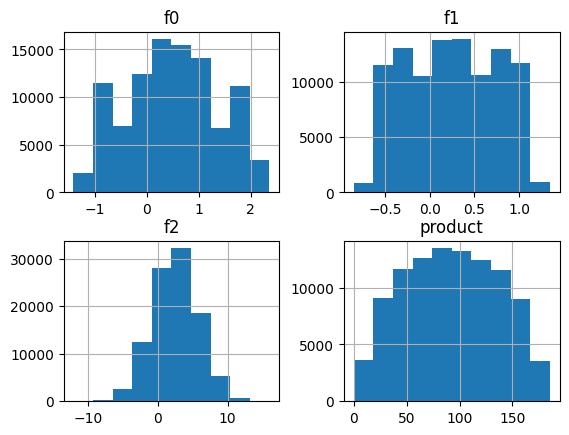

region 1


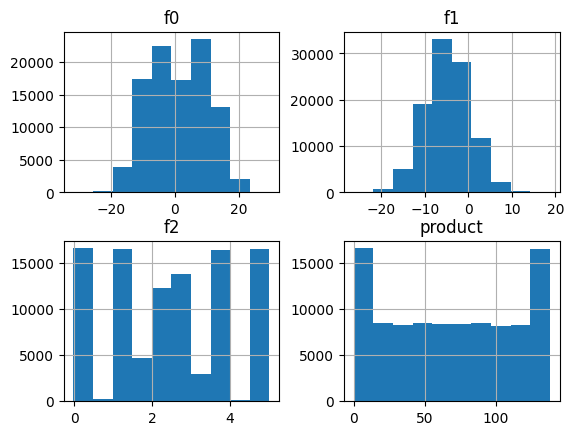

region 2


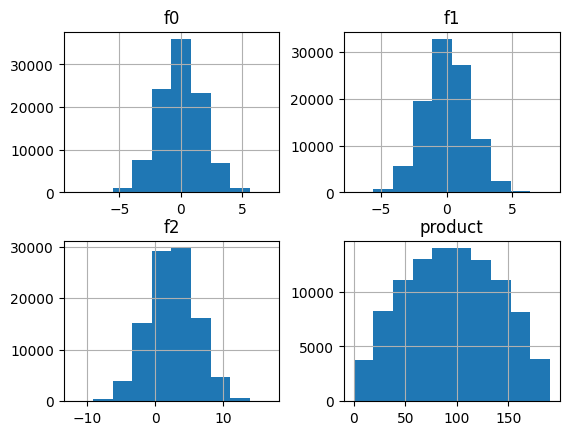

In [7]:
for i in range (3):
    print('region', i)
    region[i].hist();
    plt.show()

region 0


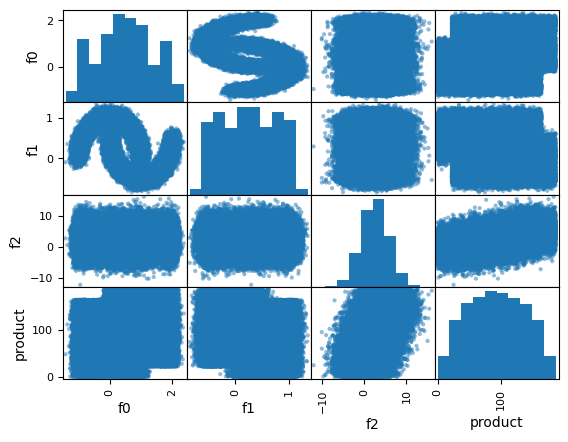

region 1


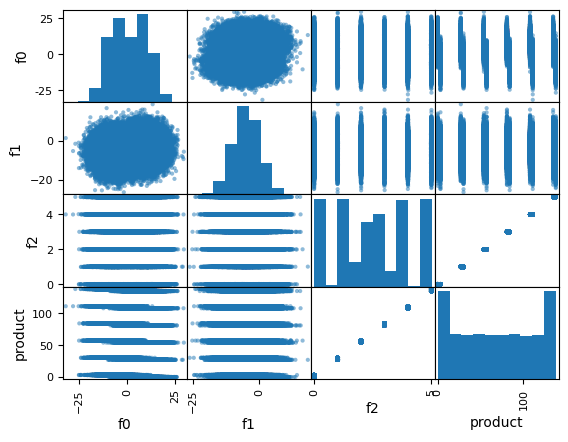

region 2


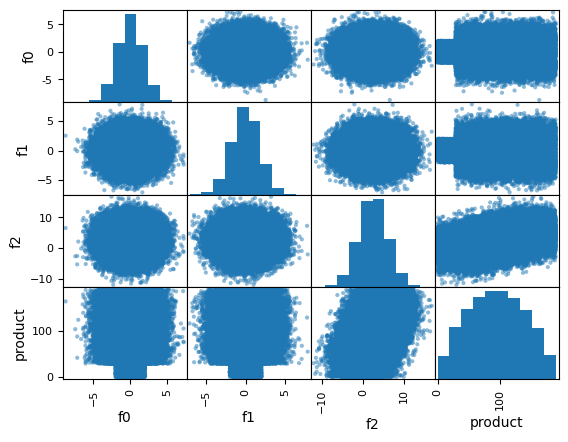

In [8]:
for i in range (3):
    print('region', i)
    pd.plotting.scatter_matrix(region[i]);
    plt.show()

Построим матрицы корреляций

<ipython-input-9-f1ae7fcf4aad>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(region[i].corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm',)


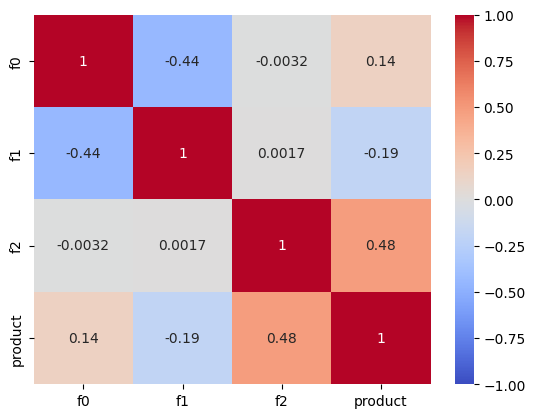

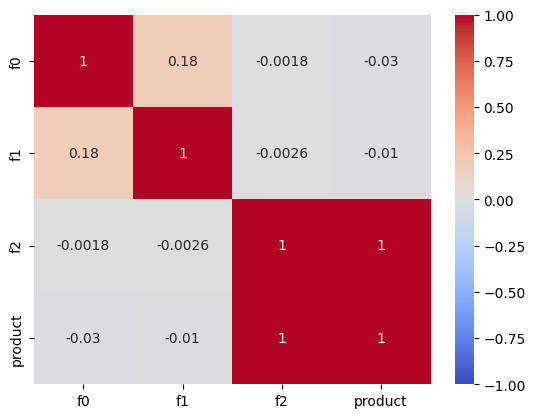

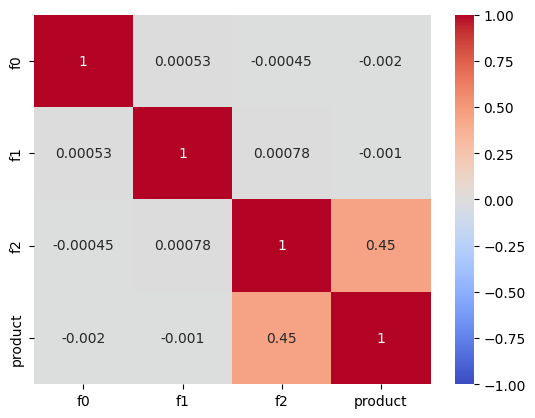

In [9]:
for i in range(3):
    sns.heatmap(region[i].corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm',)
    plt.show()

**Обнаружена высокая корреляция признака f2 с целевым.**

Создадим функцию для подготовки данных, которая удалит ненужный в анализе столбец id, разобьёт данные на выборки в заданном соотношений и произвёдет масштабирование признаков.

In [10]:
def prepare_data(df, test_size = 0.25, random_state = 42, scaling = True):
    features = df.drop(['id', 'product'], axis = 1)
    target = df['product']
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = test_size, random_state = random_state)
    if scaling:
        scaler = StandardScaler()
        scaler.fit(x_train)
        index = x_train.index
        x_train = pd.DataFrame(scaler.transform(x_train), index = index)
        index = x_test.index
        x_test = pd.DataFrame(scaler.transform(x_test), index = index)
    return(x_train, x_test, y_train, y_test)

In [11]:
x_train = []
x_test = []
y_train = []
y_test = []

for i in range(3):
    x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = prepare_data(region[i])
    x_train.append(x_train_tmp)
    x_test.append(x_test_tmp)
    y_train.append(y_train_tmp)
    y_test.append(y_test_tmp)
    print(y_train_tmp.shape[0], y_test_tmp.shape[0])

75000 25000
75000 25000
75000 25000


Проверим что распределение целевого признака в выборках совпадает с исходным

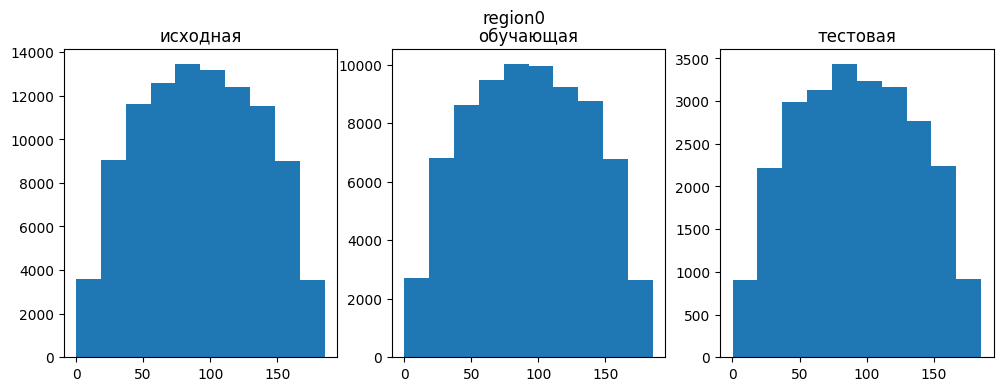

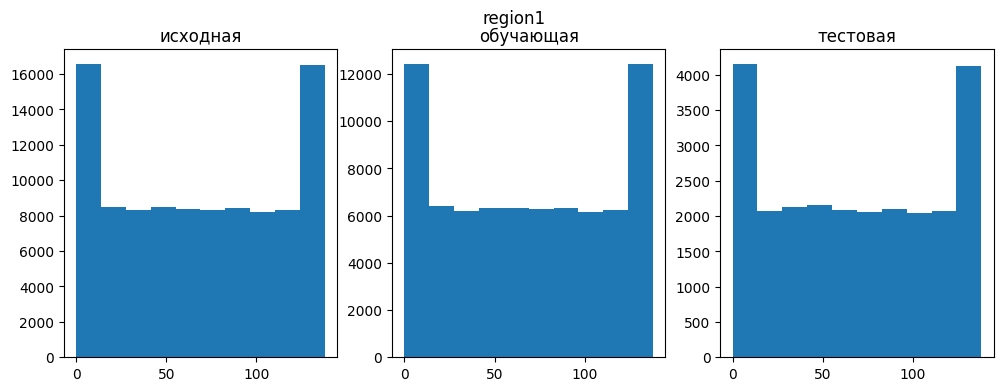

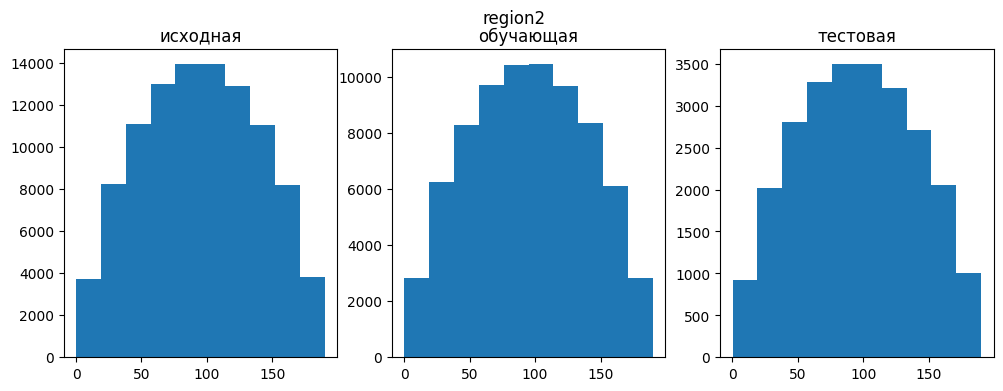

In [12]:
for i in range(3):
    fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'region{i}')
    ax1.hist(region[i]['product'])
    ax1.set_title('исходная')
    ax2.hist(y_train[i])
    ax2.set_title('обучающая')
    ax3.hist(y_test[i])
    ax3.set_title('тестовая')

## Обучение и проверка модели

Обучим линейные регрессоры на данных регионов, расчитаем RMSE и средние предсказанные запасы сырья

In [13]:
model = []
predicts = []
RMSE = []
means = []
true_means = []
for i in range (3):
    model.append(LinearRegression())
    model[i].fit(x_train[i], y_train[i])
    predicts.append(pd.Series(model[i].predict(x_test[i]), index = x_test[i].index))
    RMSE.append(mean_squared_error(y_test[i], predicts[i]) ** 0.5)
    means.append(predicts[i].mean())
    true_means.append(y_test[i].mean())

regional_summary = pd.DataFrame(zip(means, true_means, RMSE), columns = ['predicted_mean', 'true_mean', 'rmse'])
regional_summary

,predicted_mean,true_mean,rmse
0,92.398800,92.325956,37.756600
1,68.712878,68.725381,0.890280
2,94.771024,95.150999,40.145872


**Модели 0 и 2 регионов имеют очень высокие значения RMSE, что говорит о низкой точности предсказаний, однако средний предсказанный объём близок к реальному**

## Подготовка к расчёту прибыли

Подготовим необходимые параметры из условия и расчитаем минимальный объём продукта для безубыточной разработки

In [14]:
total_points = 500
best_points = 200
budget = 10 ** 10
income_per_unit = 450 * 10 ** 3
losses_threshold = 0.025
bootstrap_samples = 1000

minimal_product_volume = (budget / income_per_unit)
minimal_product_volume, minimal_product_volume / best_points

(22222.222222222223, 111.11111111111111)

**Минимальный общий объём продукта - 22.2 млн. баррелей, минимальный средний объём продукта на скважину - 111 тыс. баррелей, что превышает средний объём продукта в каждом регионе**

## Расчёт прибыли и рисков

Подготовим функцию для расчёта прибыли. Функция получает на вход номер региона и индекс отобранных точек, после чего считает суммарную предсказанную и истинную прибыли для 200 лучших точек. По умолчанию будем считать прибыиль в млрд. руб.

In [15]:
def get_income(region, index, in_billions = True):
    best_predicted_points = predicts[region][index].sort_values().tail(best_points)
    predicted_income = best_predicted_points.sum() * income_per_unit - budget
    true_predicted_points = y_test[region][best_predicted_points.index]
    true_income = true_predicted_points.sum() * income_per_unit - budget
    if in_billions:
        predicted_income /= 10 ** 9
        true_income /= 10 ** 9
    return([predicted_income, true_income])

Расчитаем предсказанную и истинную прибыль по предсказаниям модели

In [16]:
predicted_income = []
true_income = []
for i in range(3):
    pred_inc, true_inc = get_income(i, y_test[i].index)
    predicted_income.append(pred_inc)
    true_income.append(true_inc)
regional_summary['predicted_income'] = predicted_income
regional_summary['true_income'] = true_income
regional_summary[['predicted_income', 'true_income']]

,predicted_income,true_income
0,3.896658,3.359141
1,2.486938,2.415087
2,3.377982,2.598572


Применим технику bootstrap - сгененрируем 1000 случайных выборок по 500 точек, после чего для 200 лучших расчитаем предсказанную и истинную прибыли

In [17]:
samples_income = []
state = RandomState(42)
for i in range(3):
    samples_income.append([])
    for j in range(bootstrap_samples):
        sample = y_test[i].sample(total_points, replace = True, random_state = state)
        samples_income[i].append(get_income(i, sample.index))
    samples_income[i] = pd.DataFrame(samples_income[i], columns = ['predicted', 'true'])

Построим распределение прибыли по регионам

region 0


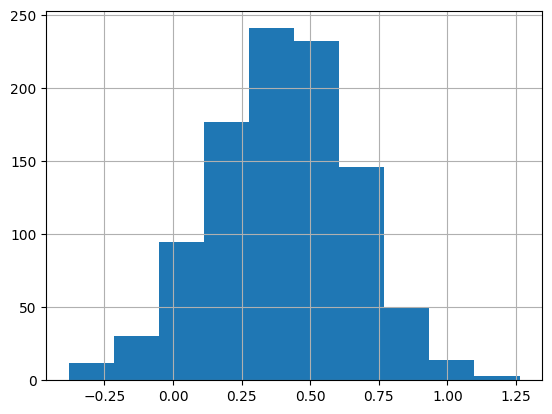

region 1


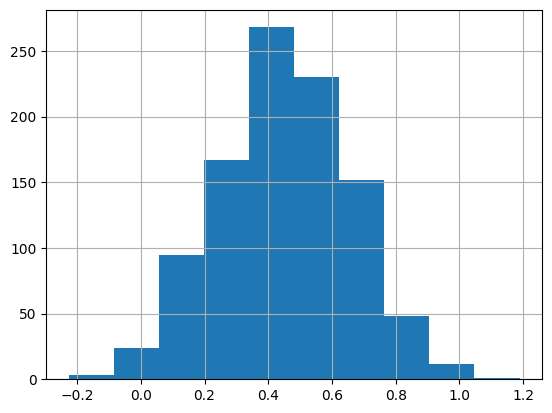

region 2


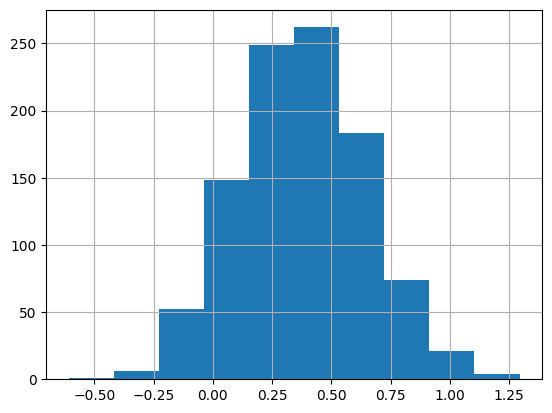

In [18]:
for i in range(3):
    print(f'region {i}')
    samples_income[i]['true'].hist()
    plt.show()

In [19]:
regional_summary['0.025_quantile'] = [samples_income[i]['true'].quantile(0.025) for i in range(3)]
regional_summary['0.975_quantile'] = [samples_income[i]['true'].quantile(0.975) for i in range(3)]
regional_summary[['0.025_quantile', '0.975_quantile']]

,0.025_quantile,0.975_quantile
0,-0.110468,0.897460
1,0.052309,0.830146
2,-0.127779,0.907923


**Значения границ доверительного интервала региона 1 значительно выше, чем у регионов 0 и 2**

Вероятность убытков оценим как отношение выборок с отрицательной прибылью к общему числу выборок

In [20]:
regional_summary['losses_probability'] = [(samples_income[i]['true'] < 0).mean() for i in range (3)]
regional_summary['high_losses_probability'] = regional_summary['losses_probability'] > losses_threshold
regional_summary[['losses_probability', 'high_losses_probability']]

,losses_probability,high_losses_probability
0,0.060,True
1,0.009,False
2,0.075,True


**Вероятности убытков для регионов 0 и 1 превышают пороговое значение в 2.5%**

<Axes: >

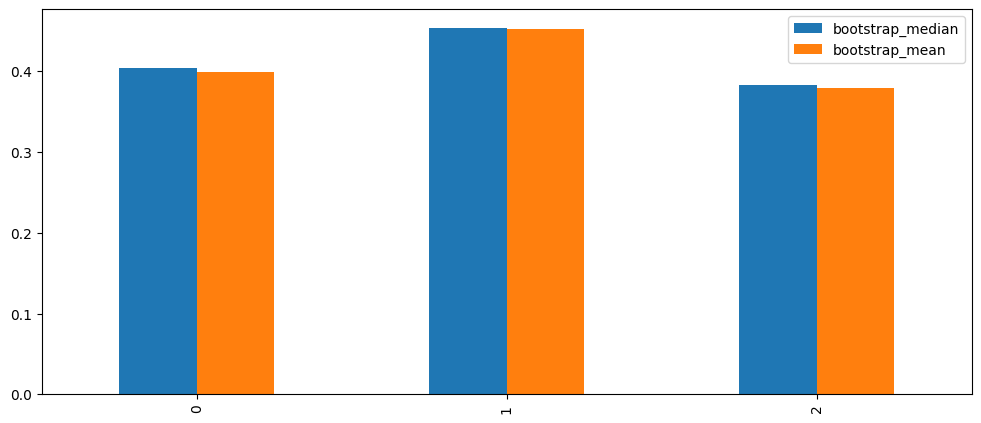

In [21]:
regional_summary['bootstrap_median'] = [samples_income[i]['true'].median() for i in range(3)]
regional_summary['bootstrap_mean'] = [samples_income[i]['true'].mean() for i in range(3)]
regional_summary[['bootstrap_median', 'bootstrap_mean']].plot(kind = 'bar', figsize = (12, 5))

In [22]:
regional_summary

,predicted_mean,true_mean,rmse,predicted_income,true_income,0.025_quantile,0.975_quantile,losses_probability,high_losses_probability,bootstrap_median,bootstrap_mean
0,92.398800,92.325956,37.756600,3.896658,3.359141,-0.110468,0.897460,0.060,True,0.403781,0.399575
1,68.712878,68.725381,0.890280,2.486938,2.415087,0.052309,0.830146,0.009,False,0.453802,0.452577
2,94.771024,95.150999,40.145872,3.377982,2.598572,-0.127779,0.907923,0.075,True,0.383124,0.378706


Итог: несмотря на то что показатель истинной прибыли для 0 и 2 региона выше, чем для региона 1, модели для этих регионов обладают низкой точнностью предсказаний, а метрики региона 1, полученные бутстрэпом (доверительный интервал, средняя и медианная прибыли) выше. Кроме того вероятность рисков в регионах 0 и 2 выше порогового значения

**Для разработки рекомендован регион 1**

## Вывод

Изучены данные о скважинах из трёх регионов.
- Данные прочитаны и собраны в список для удобства дальнейшей работы
- Проведена проверка данных
    - пропусков не обнаружено
    - дубликатов не обнаружено
- Изучено распределение признаков
    - самую высокую корреляцию с целевым показывает признак f2 (около 0.5 для регионов 0 и 2 и 0.99 для региона 1)
- Произведено разбиение данных на обучающую и тестовую выборки в соотношении 0.75 : 0.25
    - выборки собраны в списки, аналогично исходным данным
    - проверены размеры выборок
    - проверено распределение целевого признака в получившихся выборках на соответствие исходному
- Обучены модели линейной регрессии
    - сделаны предсказания
    - расчитано значение RMSE и средний предсказанный объём сырья:
        - регион 0: RMSE - 37.8, средний предсказанный объём - 92.4, средний реальный объём - 92.3
        - регион 1: RMSE - 0.9, средний предсказанный объём - 68.7, средний реальный объём - 68.7
        - регион 2: RMSE - 40.1, средний предсказанный объём - 94.8, средний реальный объём - 95.2
    - RMSE 0 и 1 регионов примерно в 40 раз превышает RMSE региона 1, что говорит о низкой точности моделей 0 и 1
    - средние предсказанные объёмы близки к реальным для всех регионов
- Выполнен расчёт прибыли
    - подготовлена функция расчёта предсказанной и истинной прибыли
    - расчитана максимальная предсказанная и реальная прибыли в млрд. руб.:
        - регион 0: предсказанная - 3.9, реальная - 3.36
        - регион 1: предсказанная - 2.49, реальная - 2.42
        - регион 2: предсказанная - 3.38, реальная - 2.6
    - техникой bootstrap получены 1000 выборок по 500 точек, для 200 точек каждой выборки были расчитаны предсказанная и истинная прибыли
    - построены гистограммы распределения прибыли
    - расчитаны 95% доверительные интервалы:
        - регион 0: -0.11 - 0.89
        - регион 1: 0.05 - 0.83
        - регион 2: -0.13 - 0.9
    - расчитаны средние и медианные значения прибыли на полученных выборках:
        - регион 0: медианное - 0.4, среднее - 0.4
        - регион 1: медианное - 0.45, среднее - 0.45
        - регион 2: медианное - 0.38, среднее - 0.38
    - расчитаны риски убытков
        - регион 0: 6%
        - регион 1: 0.9%
        - регион 2: 7.5%
    - для разработки рекомендован регион 1, т.к
        - предсказания модели по региону значительно точнее регионов 0 и 2
        - средняя и медианная прибыли, полученные по bootstrap выше регионов 0 и 2
        - значение рисков меньше порогового (2.5%)